# EGFR Bioactivity EDA (Teaching-Style)
This notebook explores your curated EGFR dataset (`EGFR_03_bioactivity_data_curated.csv`). It’s written for non-specialists with step-by-step explanations.

In [ ]:
!pip install rdkit-pypi umap-learn scikit-learn matplotlib pandas numpy --quiet

## Load dataset and view data summary

Shape: (10074, 4)

Columns: ['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'class']

Data types:
 molecule_chembl_id     object
canonical_smiles       object
standard_value        float64
class                  object
dtype: object

Missing values:
 molecule_chembl_id    0
canonical_smiles      0
standard_value        0
class                 0
dtype: int64

log10(IC50) description:
 count    10074.000000
mean         2.486618
std          1.488669
min         -8.299989
25%          1.434967
50%          2.427810
75%          3.724276
max          7.740363
Name: standard_value, dtype: float64

pIC50 description:
 count    10074.000000
mean         6.513382
std          1.488669
min          1.259637
25%          5.275724
50%          6.572190
75%          7.565033
max         17.299989
Name: standard_value, dtype: float64


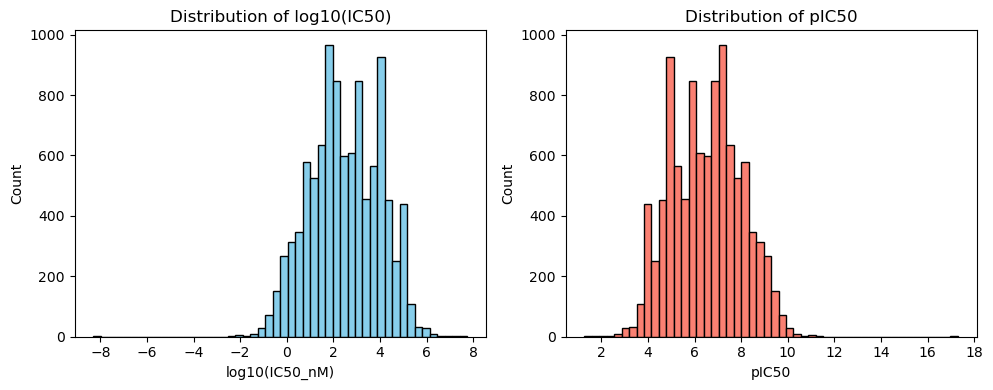

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1. Load dataset
# Adjust this path to where your file is located
df = pd.read_csv("EGFR_03_bioactivity_data_curated.csv")

# 2. Get Basic about the dataset
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())

# 3. Calculate log10(IC50) and pIC50 (not adding to df)
# Ensure standard_value is numeric
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')

log10_ic50 = np.log10(df['standard_value'])
pIC50 = 9 - log10_ic50

# 4. Describe the calculated values
print("\nlog10(IC50) description:\n", log10_ic50.describe())
print("\npIC50 description:\n", pIC50.describe())

# 5. Visualize distributions
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(log10_ic50.dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of log10(IC50)')
plt.xlabel('log10(IC50_nM)')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(pIC50.dropna(), bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of pIC50')
plt.xlabel('pIC50')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


## Sanitizing the SMILES strings
The following functions will check for poorly formatted smiles and sanitized the affected molecules

In [32]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import MolToSmiles

# 6. Define function to check SMILES format+    
def check_smiles_format(df_in: pd.DataFrame, column_name: str = 'canonical_smiles') -> pd.DataFrame:
    """
    Returns a DataFrame of ONLY the poorly formatted rows.
    Never returns None. If nothing is flagged or the column is missing, returns an empty DataFrame.
    """
    # Guard: required column
    if column_name not in df_in.columns:
        print(f"[check_smiles_format] Column '{column_name}' not found. Returning empty DataFrame.")
        return pd.DataFrame(columns=list(df_in.columns) + ['is_poorly_formatted'])

    df_local = df_in.copy()

    def is_bad(s):
        if not isinstance(s, str) or s.strip() == '':
            return True
        if s.count('[') != s.count(']'):
            return True
        if s.count('(') != s.count(')'):
            return True
        if s.startswith('.') or s.endswith('.') or '.' in s:
            return True
        return False

    try:
        df_local['is_poorly_formatted'] = df_local[column_name].apply(is_bad)
        out = df_local[df_local['is_poorly_formatted']]
        
        # Always return a DataFrame
        return out if not out.empty else pd.DataFrame(columns=df_local.columns)
    
    except Exception as e:
        print(f"[check_smiles_format] Error: {e}. Returning empty DataFrame.")
        return pd.DataFrame(columns=list(df_in.columns) + ['is_poorly_formatted'])


#Initialize standardization tools
_SALT_REMOVER  = SaltRemover()
_METAL_DC      = rdMolStandardize.MetalDisconnector()
_FRAG_REMOVER  = rdMolStandardize.FragmentRemover()
_LFC           = rdMolStandardize.LargestFragmentChooser(preferOrganic=True)
_NORMALIZER    = rdMolStandardize.Normalizer()
_REIONIZER     = rdMolStandardize.Reionizer()

def _tautomerize_if_available(mol):
    # Robust across RDKit builds
    if hasattr(rdMolStandardize, "TautomerEnumerator"):
        te = rdMolStandardize.TautomerEnumerator()
        if hasattr(te, "Canonicalize"): return te.Canonicalize(mol)
        if hasattr(te, "canonicalize"): return te.canonicalize(mol)
    if hasattr(rdMolStandardize, "TautomerCanonicalizer"):
        tc = rdMolStandardize.TautomerCanonicalizer()
        if hasattr(tc, "Canonicalize"): return tc.Canonicalize(mol)
        if hasattr(tc, "canonicalize"): return tc.canonicalize(mol)
    return mol

def standardize_molecule(mol: Chem.Mol, do_tautomer: bool = False) -> Chem.Mol | None:
    """
    Metal disconnect; salt/solvent strip; fragment cleanup; largest organic fragment;
    normalize; reionize; (optional) tautomer canonicalization.
    Returns standardized molecule or None if nothing remains.
    """
    if mol is None:
        return None
    try:
        # ensure a clean starting point
        Chem.SanitizeMol(mol)

        # 1) break metal–ligand bonds first
        mol = _METAL_DC.Disconnect(mol)

        # 2) strip salts/solvates (keep something if everything would be removed)
        mol = _SALT_REMOVER.StripMol(mol, dontRemoveEverything=True)

        # 3) drop nuisance/known inorganic fragments
        mol = _FRAG_REMOVER.remove(mol)

        # 4) keep only the largest ORGANIC fragment (i.e., parent)
        mol = _LFC.choose(mol)

        # 5) normalize and reionize to consistent representation
        mol = _NORMALIZER.normalize(mol)
        mol = _REIONIZER.reionize(mol)

        # 6) optional: collapse tautomers to a canonical form
        if do_tautomer:
            mol = _tautomerize_if_available(mol)

        # guard: empty molecules → None
        if mol is None or mol.GetNumAtoms() == 0:
            return None

        return mol
    except Exception:
        return None

def standardize_smiles(smi: str, do_tautomer: bool = False) -> str | None:
    """Convenience: SMILES, standardized SMILES (or None)."""
    if not isinstance(smi, str) or not smi.strip():
        return None
    try:
        m = Chem.MolFromSmiles(smi, sanitize=False)
        if m is None:
            return None
        m = standardize_molecule(m, do_tautomer=do_tautomer)
        return MolToSmiles(m, isomericSmiles=True, canonical=True) if m else None
    except Exception:
        return None


[00:17:49] Initializing MetalDisconnector
[00:17:49] Initializing Normalizer


In [ ]:
df["original_smiles"]  = df["canonical_smiles"]
df["corrected_smiles"] = pd.NA
df["correction_status"] = "unchanged"

# Run your light validator (shows what you'd *intend* to fix)
bad = check_smiles_format(df, "canonical_smiles")
print(f"Flagged by light validation: {len(bad)}")

# Standardize ONLY the flagged rows (fast + focused)
for idx in bad.index:
    fixed = standardize_smiles(df.at[idx, "canonical_smiles"], do_tautomer=False)  # set True if you want it
    if fixed is not None and fixed != df.at[idx, "canonical_smiles"]:
        df.at[idx, "canonical_smiles"]  = fixed
        df.at[idx, "corrected_smiles"]  = fixed
        df.at[idx, "correction_status"] = "corrected"
    elif fixed is None:
        df.at[idx, "correction_status"] = "unresolved"

#Show it worked (clear, quick checks)
after = check_smiles_format(df, "canonical_smiles")
print(f"Still flagged after standardization: {len(after)}")

from rdkit import Chem
def _can_parse(s): 
    try: return Chem.MolFromSmiles(s) is not None
    except: return False
print(f"Parsable by RDKit: {df['canonical_smiles'].apply(_can_parse).mean()*100:.1f}%")

display(df.loc[df["correction_status"]=="corrected",
               ["original_smiles","canonical_smiles"]].head(10))


Flagged by light validation: 243
Still flagged after standardization: 0


[00:17:58] Running MetalDisconnector
[00:17:58] Running FragmentRemover
[00:17:58] Running LargestFragmentChooser
[00:17:58] Running Normalizer
[00:17:58] Running MetalDisconnector
[00:17:58] Running FragmentRemover
[00:17:58] Running LargestFragmentChooser
[00:17:58] Running Normalizer
[00:17:58] Running MetalDisconnector
[00:17:58] Running FragmentRemover
[00:17:58] Running LargestFragmentChooser
[00:17:58] Running Normalizer
[00:17:58] Running MetalDisconnector
[00:17:58] Running FragmentRemover
[00:17:58] Running LargestFragmentChooser
[00:17:58] Running Normalizer
[00:17:58] Running MetalDisconnector
[00:17:58] Running FragmentRemover
[00:17:58] Running LargestFragmentChooser
[00:17:58] Running Normalizer
[00:17:58] Running MetalDisconnector
[00:17:58] Running FragmentRemover
[00:17:58] Running LargestFragmentChooser
[00:17:58] Running Normalizer
[00:17:58] Running MetalDisconnector
[00:17:58] Running FragmentRemover
[00:17:58] Running LargestFragmentChooser
[00:17:58] Running Nor

Parsable by RDKit: 100.0%


,original_smiles,canonical_smiles
156,C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN...,C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN...
431,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCNCC1.Cl,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCNCC1
483,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OC/C=C/CN1CCCC...,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OC/C=C/CN1CCCC1
485,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCN(C)CC1.Cl,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCN(C)CC1
497,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCCCN1CCCC1.Cl,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCCCN1CCCC1
500,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCCCN1CCN(C)CC...,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCCCN1CCN(C)CC1
505,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1.Cl,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
520,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCCCN1CCN(C)CC...,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCCCN1CCN(C)CC1
551,COc1cc2c(Nc3cc(O)c(C)cc3F)ncnc2cc1OCC1CCN(C)CC...,COc1cc2c(Nc3cc(O)c(C)cc3F)ncnc2cc1OCC1CCN(C)CC1
556,COc1cc2c(Nc3cc(O)c(Cl)cc3F)ncnc2cc1OCC1CCN(C)C...,COc1cc2c(Nc3cc(O)c(Cl)cc3F)ncnc2cc1OCC1CCN(C)CC1


In [37]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class,original_smiles,corrected_smiles,correction_status
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,41.0,active,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,<NA>,unchanged
1,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,170.0,active,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,<NA>,unchanged
2,CHEMBL137635,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,9300.0,intermediate,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,<NA>,unchanged
3,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,500000.0,inactive,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,<NA>,unchanged
4,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,3000000.0,inactive,O=C(O)/C=C/c1ccc(O)cc1,<NA>,unchanged
...,...,...,...,...,...,...,...
10069,CHEMBL4778541,CC(C)(C)c1ccc(C(=O)Nc2cn3cc(-n4ccnc4)ccc3n2)cc1,20000.0,inactive,CC(C)(C)c1ccc(C(=O)Nc2cn3cc(-n4ccnc4)ccc3n2)cc...,CC(C)(C)c1ccc(C(=O)Nc2cn3cc(-n4ccnc4)ccc3n2)cc1,corrected
10070,CHEMBL3622821,CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3...,10000.0,inactive,CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3...,<NA>,unchanged
10071,CHEMBL1852688,CCN1CCN(c2ccc(Nc3cc(N(C)C(=O)Nc4c(Cl)c(OC)cc(O...,10000.0,inactive,CCN1CCN(c2ccc(Nc3cc(N(C)C(=O)Nc4c(Cl)c(OC)cc(O...,<NA>,unchanged
10072,CHEMBL3643413,CCC(=O)N1CC[C@H](Nc2ncnc3c2CN(c2cnc(OC)c(C(F)(...,10000.0,inactive,CCC(=O)N1CC[C@H](Nc2ncnc3c2CN(c2cnc(OC)c(C(F)(...,<NA>,unchanged


A quick look at the correction status of the original smiles

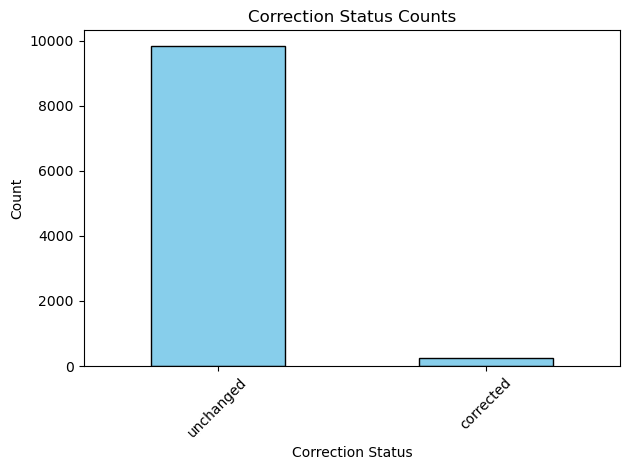

In [36]:
df['correction_status'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Correction Status Counts')
plt.xlabel('Correction Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3D molecule rendering

View the molecular structure of the molecule at index 431 of the dataset, the original smiles (COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCNCC1.Cl) and the sanitized smiles (COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCNCC1).

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

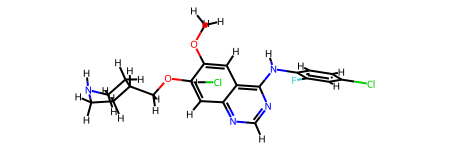

In [54]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import rdDistGeom

IPythonConsole.ipython_3d=True
smiles_list = [
    'COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCNCC1',
    'COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCNCC1.Cl'
]
m2=Chem.MolFromSmiles(smiles_list[1]); m3=Chem.MolFromSmiles(smiles_list[0])
mh=Chem.AddHs(m2); mi=Chem.AddHs(m3)
rdDistGeom.EmbedMolecule(mh, randomSeed=42); rdDistGeom.EmbedMolecule(mi, randomSeed=42)
mh



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

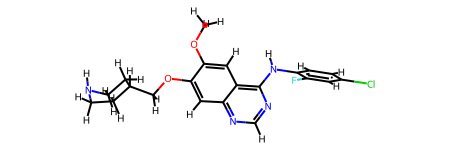

In [55]:
mi

## Save the df to csv file

In [56]:
df.to_csv("EGFR_04_bioactivity_data_curated_standardized.csv", index=False)